# Supervised Learning with Decision Trees

In [3]:
import os
from PIL import Image, ImageFilter
import numpy as np 
import logging

#Dataset Directory 
alphabet_dir = "ASL_Dataset/Train"

images = []
labels = []


In [4]:
max_images_per_folder = 10
size = (256, 256)  
def horizontal_flip(image):
    flipped_image = image.transpose(Image.FLIP_LEFT_RIGHT)
    return flipped_image

def remove_noise(image):
    pil_image = Image.fromarray(np.uint8(image*255))  
    denoised_image = pil_image.filter(ImageFilter.GaussianBlur(radius=2))
    denoised_array = np.array(denoised_image) / 255.0  
    return denoised_array

images = []
labels = []

for folder_name in os.listdir(alphabet_dir):
    folder_path = os.path.join(alphabet_dir, folder_name)

    image_counter = 0

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            if image_counter >= max_images_per_folder:
                break
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)

            image = image.resize(size)

            image = image.convert('L')

            image = np.array(image) / 255.0

            image = remove_noise(image)

            images.append(image)
            labels.append(folder_name)
            image_counter += 1

images = np.array(images)
labels = np.array(labels)

In [5]:
len(labels)

280

# PCA

In [6]:
# Reshape the image data
num_images = images.shape[0]
flattened_images = images.reshape(num_images, -1)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standardized_images = scaler.fit_transform(flattened_images)

from sklearn.decomposition import PCA

num_components = 10  # Number of principal components to keep
pca = PCA(n_components=num_components)
reduced_images = pca.fit_transform(standardized_images)

reconstructed_images = pca.inverse_transform(reduced_images)



In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_rem, y_train, y_rem = train_test_split(reconstructed_images, labels, test_size=0.4, random_state=2411)

X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)



In [9]:
import os
  
n_cpu = os.cpu_count()
print("Number of CPUs in the system:", n_cpu)

Number of CPUs in the system: 12


In [10]:
from sklearn.model_selection import GridSearchCV

params = {'criterion': ['gini', 'entropy'],
                    'max_depth': list(range(7,13)),
                    'min_samples_split': [2, 4, 6],
                    'min_samples_leaf': [1, 2, 3]
                    }
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=2411), params, verbose=4, cv=3, n_jobs=-1)
grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV 2/3] END criterion=gini, max_depth=7, min_samples_leaf=2, min_samples_split=2;, score=0.268 total time=  10.6s
[CV 2/3] END criterion=gini, max_depth=7, min_samples_leaf=1, min_samples_split=6;, score=0.268 total time=  10.7s
[CV 2/3] END criterion=gini, max_depth=7, min_samples_leaf=1, min_samples_split=4;, score=0.268 total time=  10.8s
[CV 2/3] END criterion=gini, max_depth=7, min_samples_leaf=1, min_samples_split=2;, score=0.232 total time=  10.9s
[CV 3/3] END criterion=gini, max_depth=7, min_samples_leaf=2, min_samples_split=2;, score=0.179 total time=  11.1s
[CV 1/3] END criterion=gini, max_depth=7, min_samples_leaf=2, min_samples_split=2;, score=0.214 total time=  11.1s
[CV 3/3] END criterion=gini, max_depth=7, min_samples_leaf=1, min_samples_split=6;, score=0.179 total time=  11.1s
[CV 1/3] END criterion=gini, max_depth=7, min_samples_leaf=1, min_samples_split=2;, score=0.214 total time=  11.2s
[CV 1/3] END crit

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=2411),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [7, 8, 9, 10, 11, 12],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4, 6]},
             verbose=4)

In [11]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_depth=10, min_samples_split=4, random_state=2411)

In [12]:
grid_search_cv.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 4}

In [13]:
grid_search_cv.best_score_

0.2738095238095238

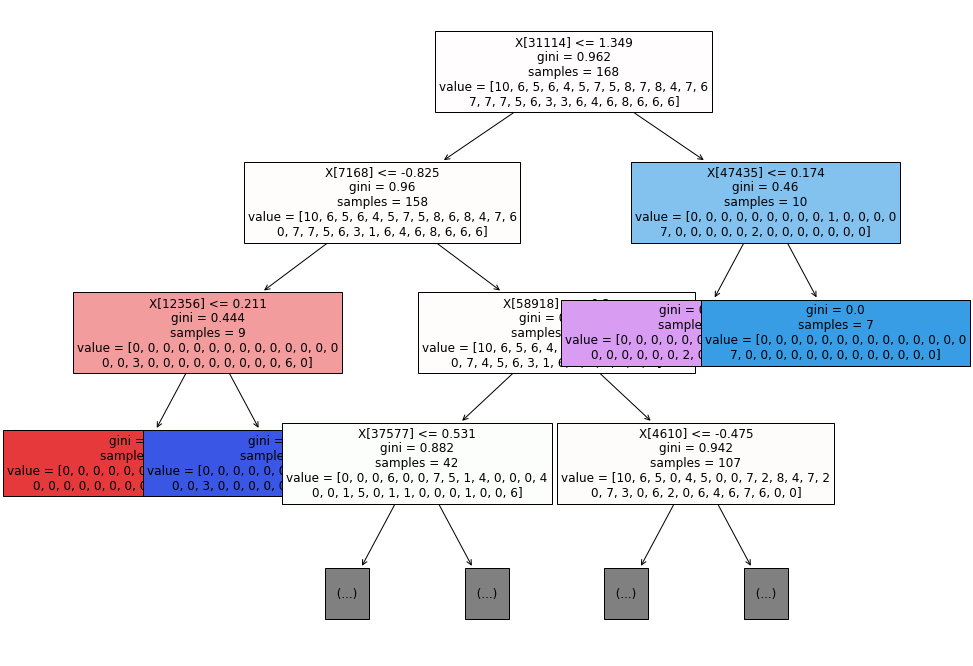

In [14]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(15, 12))
plot_tree(grid_search_cv.best_estimator_, max_depth=3, filled=True, fontsize=12)
plt.savefig("decision_tree.png", format="png")  # Save the plot as a PNG image
plt.show()